Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from scipy import signal
from scipy.interpolate import interp1d
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.svm import SVR

#Phase 1

Loading data

In [ ]:
data_train = np.load('s1_train.npy', allow_pickle=True);
data_test =  np.load('s1_test.npy' , allow_pickle=True);

Plotting some samples

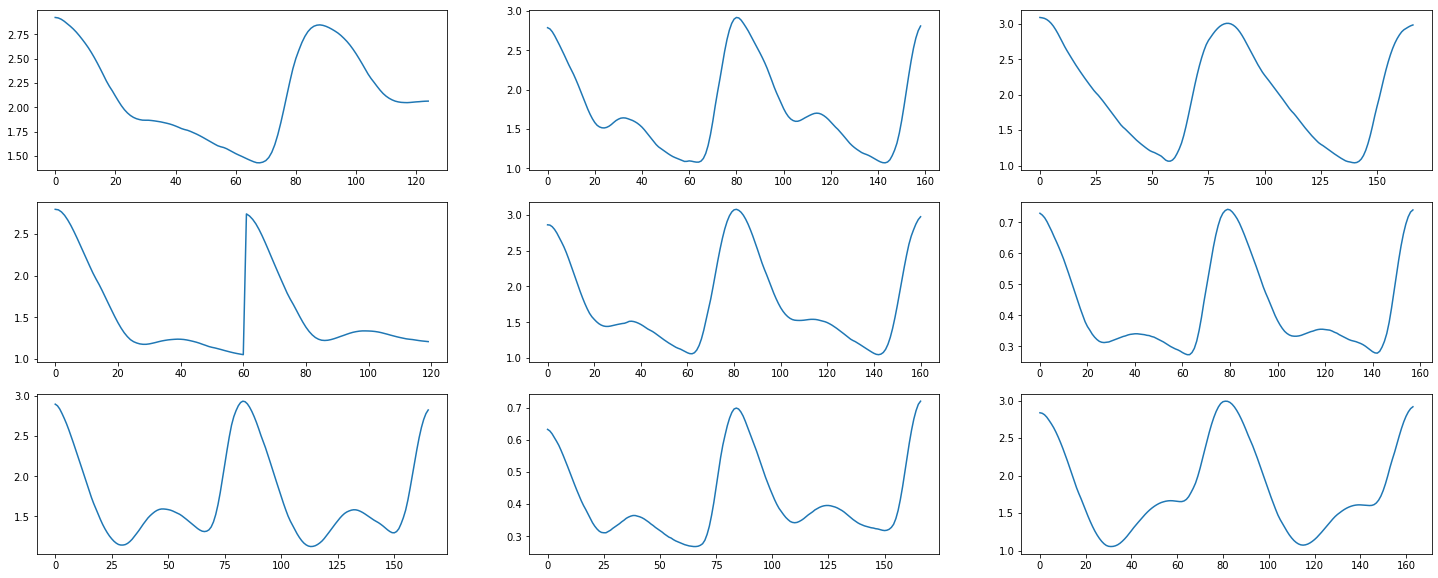

In [ ]:
# confige figure
plt.figure(figsize=(25,10));

# plot first 9 train samples
for i in range(1,10):
  plt.subplot(3,3,i);
  plt.plot(data_train[i,0]);

# show figure
plt.show();

Upsampling data

In [ ]:
length = 200;
n_train = data_train.shape[0];
n_test = data_test.shape[0];

# upsample X_train
X_train = np.zeros((n_train, length));
for i in range(n_train):
  l = data_train[i,0].shape[0];
  xs = range(l);
  xp = np.linspace(0, l-1, num=length);
  ys = data_train[i,0];
  interp_func = interp1d(xs, ys); 
  X_train[i] = interp_func(xp);

# upsample X_test
X_test=np.zeros((n_test,length));
for i in range(n_test):
  l = data_test[i,0].shape[0];
  xs = range(l);
  xp = np.linspace(0, l-1, num=length);
  ys = data_test[i,0];
  interp_func = interp1d(xs, ys);
  X_test[i] = interp_func(xp);

# create y_train matrix
y_train = data_train[:,1].astype('float64');

Reduce dimensions

In [ ]:
#************************ X_train **************************
# min max scale
min_max_scaler = MinMaxScaler();
X_train = min_max_scaler.fit_transform(X_train.T).T;

# standard scale
scaler = StandardScaler();
X_train_s = scaler.fit_transform(X_train);

# reduction dimensions by PCA
length_r = 30;
pca = PCA(n_components = length_r);
X_train_r = pca.fit_transform(X_train_s);

#************************ X_test **************************
# min max scale
min_max_scaler = MinMaxScaler();
X_test = min_max_scaler.fit_transform(X_test.T).T;

# standard scale
X_test_s = scaler.transform(X_test);

# reduction dimensions by PCA
X_test_r = pca.transform(X_test_s);

Baseline model

In [ ]:
# configure the cross-validation procedure
kf = KFold(n_splits=3, shuffle=True, random_state=0);
indices = kf.split(X_train_r);

# execute the cross-validation
scores = np.atleast_1d([]);
for train_idx, test_idx in indices:
  n=test_idx.shape[0];
  Y_TRAIN, Y_TEST = y_train[train_idx], y_train[test_idx];
  intercept = Y_TRAIN.mean();
  Y_PRE = np.ones(n)*intercept;
  error = mean_squared_error(Y_TEST, Y_PRE);
  scores = np.append(scores, error);

# report performance
print(f'MSE of BaseLine model = {round(scores.mean(), 3)}')

MSE of BaseLine model = 662.481


Linear regression

In [ ]:
# define the model
regr = LinearRegression();

# configure the cross-validation procedure
kf = KFold(n_splits=3, shuffle=True, random_state=0);

# execute the cross-validation
scores = cross_val_score(regr, X_train_r, y_train, cv=kf, scoring = 'neg_mean_squared_error');

# report performance
print(f'MSE of linear regression model = {round(-scores.mean(), 3)}')

MSE of linear regression model = 667.967


Ridge regression

In [ ]:
# define the model
regr = Ridge();

# configure the cross-validation procedure
kf_i = KFold(n_splits=3, shuffle=True, random_state=0);
kf_o = KFold(n_splits=3, shuffle=True, random_state=0);

# define search space
p_grid = {'alpha':[0.2, 1, 5, 10, 20, 30]};

# define search
search = GridSearchCV(regr, p_grid, cv=kf_i, scoring='neg_mean_squared_error');

# execute the nested cross-validation
scores = cross_val_score(search, X_train_r, y_train, cv=kf_o, scoring = 'neg_mean_squared_error');

# report performance
print(f'MSE of ridge regression model = {round(-scores.mean(), 3)}')

MSE of ridge regression model = 642.12


Lasso regression

In [ ]:
# define the model
regr = Lasso();

# configure the cross-validation procedure
kf_i = KFold(n_splits=3, shuffle=True, random_state=0);
kf_o = KFold(n_splits=3, shuffle=True, random_state=0);

# define search space
p_grid = {'alpha':[0.1, 0.2, 0.4, 0.8, 1, 2]};

# define search
search = GridSearchCV(regr, p_grid, cv=kf_i, scoring='neg_mean_squared_error');

# execute the nested cross-validation
scores = cross_val_score(search, X_train_r, y_train, cv=kf_o, scoring = 'neg_mean_squared_error');

# report performance
print(f'MSE of lasso regression model = {round(-scores.mean(), 3)}')

MSE of lasso regression model = 637.008


RandomForest regression

In [ ]:
# define the model
regr = RandomForestRegressor(criterion='mse', random_state=0);

# configure the cross-validation procedure
kf_i = KFold(n_splits=3, shuffle=True, random_state=0);
kf_o = KFold(n_splits=3, shuffle=True, random_state=0);

# define search space
p_grid = {'n_estimators':[100, 150],
          'min_samples_leaf':[1, 2],
          'max_depth':[3, None]};

# define search
search = GridSearchCV(regr, p_grid, cv=kf_i, scoring='neg_mean_squared_error'); 

# execute the nested cross-validation       
scores = cross_val_score(search, X_train_r, y_train, cv=kf_o, scoring = 'neg_mean_squared_error');

# report performance
print(f'MSE of RandomForest model = {round(-scores.mean(), 3)}');

MSE of RandomForest model = 516.5


AdaBoost regression

In [ ]:
# define the model
regr = AdaBoostRegressor();

# configure the cross-validation procedure
kf_i = KFold(n_splits=3, shuffle=True, random_state=0);
kf_o = KFold(n_splits=3, shuffle=True, random_state=0);

# define search space
p_grid = {'n_estimators':[50, 100, 120, 150, 200],
          'learning_rate':[0.1, 0.5, 1, 1.5, 2]};

# define search
search = GridSearchCV(regr, p_grid, cv=kf_i, scoring='neg_mean_squared_error'); 

# execute the nested cross-validation       
scores = cross_val_score(search, X_train_r, y_train, cv=kf_o, scoring = 'neg_mean_squared_error');

# report performance
print(f'MSE of AdaBoost model = {round(-scores.mean(), 3)}');

MSE of AdaBoost model = 595.075


SVR model

In [ ]:
# define the model
regr = SVR(kernel='rbf', gamma='auto');

# configure the cross-validation procedure
kf_i = KFold(n_splits=3, shuffle=True, random_state=0);
kf_o = KFold(n_splits=3, shuffle=True, random_state=0);

# define search space
p_grid = {'C':[40, 50, 55, 60, 65, 70, 80],
          'epsilon':[2, 3, 4, 5, 6]};

# define search
search = GridSearchCV(regr, p_grid, cv=kf_i, scoring='neg_mean_squared_error'); 

# execute the nested cross-validation       
scores = cross_val_score(search, X_train_r, y_train, cv=kf_o, scoring = 'neg_mean_squared_error');

# report performance
print(f'MSE of SVR model = {round(-scores.mean(), 3)}');

MSE of SVR model = 494.623


Tune SVR parameters

In [ ]:
# define the model
regr = SVR(kernel='rbf', gamma='auto');

# configure the cross-validation procedure
kf = KFold(n_splits=10, shuffle=True, random_state=0);

# define search space
p_grid = {'C':[40, 50, 55, 60, 65, 70, 80],
          'epsilon':[2, 3, 4, 5, 6]};

# define search
search = GridSearchCV(regr, p_grid, cv=kf, scoring='neg_mean_squared_error'); 

# fit model to train data
search.fit(X_train_r, y_train);

# select best estimator
model = search.best_estimator_;

# display the best values for hyper parameters
print(f'Best values for hyper parameters : {search.best_params_}')

Best values for hyper parameters : {'C': 65, 'epsilon': 6}


Predict test labels

In [ ]:
# train model
model.fit(X_train_r, y_train);

# predict labels of test samples
s1_predicted = np.round_(model.predict(X_test_r));

# display the predicted labels
df = pd.DataFrame({'Systolic':s1_predicted});
display(df);

# save predicted labels
df.to_excel('s1_labels.xlsx', index=False)

,Systolic
0,121.0
1,139.0
2,119.0
3,133.0
4,133.0
...,...
95,121.0
96,134.0
97,150.0
98,180.0


#Phase 2

Loading data

In [ ]:
data_train = np.load('s2_train.npy', allow_pickle=True);
data_test =  np.load('s2_test.npy' , allow_pickle=True);

Define functions

In [ ]:
# notch filter to remove 50 Hz
def notch_filter(sigInput):

  # configure filter
  b_notch, a_notch = signal.iirnotch(w0=50.0, Q=10.0, fs=125);

  # filter input signal
  filtered = signal.filtfilt(b_notch, a_notch, sigInput);

  return filtered

# ampd algorithm for peak detection
def ampd(sigInput, scale = 100):

  # Create preprocessing linear fit
	sigTime = np.arange(0, len(sigInput))
 
  # Detrend
	dtrSignal = (sigInput - np.polyval(np.polyfit(sigTime, sigInput, 1), sigTime)).astype(float)	
 
	N = len(dtrSignal)
	L = int(np.ceil(scale / 2.0)) - 1	

  # Generate random matrix
	LSM = np.ones([L,N], dtype='uint8')
 
  # Local minima extraction
	for k in range(1, L):
		LSM[k - 1, np.where((dtrSignal[k:N - k - 1] > dtrSignal[0: N - 2 * k - 1]) & (dtrSignal[k:N - k - 1] > dtrSignal[2 * k: N - 1]))[0]+k] = 0	

	pks = np.where(np.sum(LSM[0:np.argmin(np.sum(LSM, 1)), :], 0)==0)[0]
  
	return pks

# save samples figure in pdf file
def make_pdf(sigInput, scale_array,  limit_array):

  with PdfPages('pdf_file.pdf') as pdf:
    for x in range(0, sigInput.size):
      sc = scale_array[x];
      limit = limit_array[x];

      data = sigInput[x];
      m_idx = ampd(-data, scale=sc)
      n = (m_idx.shape[0]//10)-1

      sub_s = np.empty(n, dtype='object');
      for i in range(n):
        min_max_scaler = MinMaxScaler();
        sub_s[i] = np.ravel(min_max_scaler.fit_transform(data[m_idx[i*10]:m_idx[(i+1)*10]].reshape(-1,1)));

      f = plt.figure(figsize=(25,90))
      f.suptitle(f'salmple {x}',fontsize=30)
      for i in range(n):
        idx = ampd(sub_s[i], scale = sc)
        m = np.std(sub_s[i][idx])

        idx = ampd(-sub_s[i], scale = sc)
        v = np.std(sub_s[i][idx])

        if m<limit and v<limit:
          plt.subplot(40, 3, i+1);
          plt.plot(sub_s[i]-sub_s[i].mean());

        else:
          plt.subplot(40, 3, i+1);
          plt.plot(sub_s[i]-sub_s[i].mean(), c='red');

      pdf.savefig()
      plt.close();

Create train dataset from 50 samples

In [ ]:
# confige scale for each of 50 samples(used in ampd algorithm)
scale_array = np.ones(50)*100;
scale_array[[21,23]]=30;

# confige std limit for each of 50 samples
limit_array = np.ones(50)*0.1;
limit_array[[4,27,29,36,39,40,43,44,49]]=0.13;
limit_array[19]=0.12;
limit_array[[11,13,17,24,30,31,32,33,34,48]]=0.08;

# Remove bad samples
good_samples_idx = np.empty(50, dtype='object');
for i in range(0,50):
  sc = scale_array[i];
  limit = limit_array[i];

  data = data_train[i,0];
  bp = data_train[i,1];

  m_idx = ampd(-data, scale=sc);
  n = (m_idx.shape[0]//10)-1;

  s_idx = ampd(bp, scale=sc);
  n_s = (s_idx.shape[0]//10)-1;

  d_idx = ampd(-bp, scale=sc);
  n_d = (d_idx.shape[0]//10)-1;

  sub_samples = np.empty(n, dtype='object');

  good_idx = np.zeros(n);

  for j in range(n):
    min_max_scaler = MinMaxScaler();
    sub_samples[j] = np.ravel(min_max_scaler.fit_transform(data[m_idx[j*10]:m_idx[(j+1)*10]].reshape(-1,1)));

  for j in range(n):
    idx = ampd(sub_samples[j], scale=sc)
    p_std = np.std(sub_samples[j][idx])

    idx = ampd(-sub_samples[j], scale=sc)
    m_std = np.std(sub_samples[j][idx])

    if p_std < limit and m_std < limit and j < n_s and j < n_d:
      good_idx[j] = 1;
  
  good_samples_idx[i] = good_idx;

# creat dataset array
s=0;
for i in range(0,50):
  s += np.sum(good_samples_idx[i])//1

d_train = np.empty((int(s), 3),dtype='object')

# fill dataset array(1st column:ppg - 2nd column:systolic - 3rd column:diastolic)
id = 0;
for i in range(50):
  sc = scale_array[i];
  limit = limit_array[i];

  data = data_train[i,0];
  bp = data_train[i,1];

  m_idx = ampd(-data, scale=sc);
  n = (m_idx.shape[0]//10)-1;

  s_idx = ampd(bp, scale=sc);
  n_s = (s_idx.shape[0]//10)-1;

  d_idx = ampd(-bp, scale=sc);
  n_d = (d_idx.shape[0]//10)-1;

  sub_samples = np.empty(n, dtype='object');

  good_idx = np.zeros(n);

  for j in range(n):
    if good_samples_idx[i][j] == 1:
      d_train[id,0] = data[m_idx[j*10]:m_idx[(j+1)*10]];
      d_train[id,1] = bp[s_idx[j*10:(j+1)*10]].mean();
      d_train[id,2] = bp[d_idx[j*10:(j+1)*10]].mean();
      id +=1;


Upsample (train data)


In [ ]:
length = 1500;
n_train = d_train.shape[0];

# upsample X_train
X_train = np.zeros((n_train, length));
for i in range(n_train):
  l = d_train[i,0].shape[0];
  xs = range(l);
  xp = np.linspace(0, l-1, num=length);
  ys = d_train[i,0];
  interp_func = interp1d(xs, ys); 
  X_train[i] = interp_func(xp);

# create y_train matrix
ys_train = d_train[:, 1].astype('float64');
yd_train = d_train[:, 2].astype('float64');

Reduce dimensions (train data)

In [ ]:
# min max scale
min_max_scaler = MinMaxScaler();
X_train = min_max_scaler.fit_transform(X_train.T).T;

# standard scale
scaler = StandardScaler();
X_train_s = scaler.fit_transform(X_train);

# reduction dimensions by PCA
length_r = 200;
pca = PCA(n_components=length_r);
X_train_r = pca.fit_transform(X_train_s);

**Models for systolic blood pressure**

Baseline model


In [ ]:
# configure the cross-validation procedure
kf = KFold(n_splits=3, shuffle=True, random_state=0);
indices = kf.split(X_train_r);

# execute the cross-validation
scores = np.atleast_1d([]);
for train_idx, test_idx in indices:
  n=test_idx.shape[0];
  Y_TRAIN, Y_TEST = ys_train[train_idx], ys_train[test_idx];
  intercept = Y_TRAIN.mean();
  Y_PRE = np.ones(n)*intercept;
  error = mean_squared_error(Y_TEST, Y_PRE);
  scores = np.append(scores, error);

# report performance
print(f'MSE of BaseLine model = {round(scores.mean(), 3)}')

MSE of BaseLine model = 480.611


Linear regression

In [ ]:
# define the model
regr = LinearRegression();

# configure the cross-validation procedure
kf = KFold(n_splits=3, shuffle=True, random_state=0);

# execute the cross-validation
scores = cross_val_score(regr, X_train_r, ys_train, cv=kf, scoring = 'neg_mean_squared_error');

# report performance
print(f'MSE of linear regression model = {round(-scores.mean(), 3)}')

MSE of linear regression model = 308.647


Ridge regression

In [ ]:
# define the model
regr = Ridge();

# configure the cross-validation procedure
kf_i = KFold(n_splits=3, shuffle=True, random_state=0);
kf_o = KFold(n_splits=3, shuffle=True, random_state=0);

# define search space
p_grid = {'alpha':[0.2, 1, 5, 10, 20, 30]};

# define search
search = GridSearchCV(regr, p_grid, cv=kf_i, scoring='neg_mean_squared_error');

# execute the nested cross-validation
scores = cross_val_score(search, X_train_r, ys_train, cv=kf_o, scoring = 'neg_mean_squared_error');

# report performance
print(f'MSE of ridge regression model = {round(-scores.mean(), 3)}')

MSE of ridge regression model = 275.578


Lasso regression

In [ ]:
# define the model
regr = Lasso();

# configure the cross-validation procedure
kf_i = KFold(n_splits=3, shuffle=True, random_state=0);
kf_o = KFold(n_splits=3, shuffle=True, random_state=0);

# define search space
p_grid = {'alpha':[0.1, 0.2, 0.4, 0.8, 1, 2]};

# define search
search = GridSearchCV(regr, p_grid, cv=kf_i, scoring='neg_mean_squared_error');

# execute the nested cross-validation
scores = cross_val_score(search, X_train_r, ys_train, cv=kf_o, scoring = 'neg_mean_squared_error');

# report performance
print(f'MSE of lasso regression model = {round(-scores.mean(), 3)}')

MSE of lasso regression model = 279.627


SVR


In [ ]:
# define the model
regr = SVR(kernel='rbf', gamma='auto');

# configure the cross-validation procedure
kf_i = KFold(n_splits=3, shuffle=True, random_state=0);
kf_o = KFold(n_splits=3, shuffle=True, random_state=0);

# define search space
p_grid = {'C':[80, 90, 100],
          'epsilon':[1, 2, 3]};

# define search
search = GridSearchCV(regr, p_grid, cv=kf_i, scoring='neg_mean_squared_error'); 

# execute the nested cross-validation       
scores = cross_val_score(search, X_train_r, ys_train, cv=kf_o, scoring = 'neg_mean_squared_error');

# report performance
print(f'MSE of SVR model = {round(-scores.mean(), 3)}');

MSE of SVR model = 144.276


Tune SVR parameters

In [ ]:
# define the model
regr = SVR(kernel='rbf', gamma='auto');

# configure the cross-validation procedure
kf = KFold(n_splits=10, shuffle=True, random_state=0);

# define search space
p_grid = {'C':[80, 90, 100],
          'epsilon':[1, 2, 3]};

# define search
search = GridSearchCV(regr, p_grid, cv=kf, scoring='neg_mean_squared_error'); 

# fit model to train data
search.fit(X_train_r, ys_train);

# select best estimator
model_s = search.best_estimator_;

# display the best values for hyper parameters
print(f'Best values for hyper parameters : {search.best_params_}')

Best values for hyper parameters : {'C': 100, 'epsilon': 1}


**Models for diastolic blood pressure**

Baseline model


In [ ]:
# configure the cross-validation procedure
kf = KFold(n_splits=3, shuffle=True, random_state=0);
indices = kf.split(X_train_r);

# execute the cross-validation
scores = np.atleast_1d([]);
for train_idx, test_idx in indices:
  n=test_idx.shape[0];
  Y_TRAIN, Y_TEST = yd_train[train_idx], yd_train[test_idx];
  intercept = Y_TRAIN.mean();
  Y_PRE = np.ones(n)*intercept;
  error = mean_squared_error(Y_TEST, Y_PRE);
  scores = np.append(scores, error);

# report performance
print(f'MSE of BaseLine model = {round(scores.mean(), 3)}')

MSE of BaseLine model = 51.291


Linear regression

In [ ]:
# define the model
regr = LinearRegression();

# configure the cross-validation procedure
kf = KFold(n_splits=3, shuffle=True, random_state=0);

# execute the cross-validation
scores = cross_val_score(regr, X_train_r, yd_train, cv=kf, scoring = 'neg_mean_squared_error');

# report performance
print(f'MSE of linear regression model = {round(-scores.mean(), 3)}')

MSE of linear regression model = 47.095


Ridge regression

In [ ]:
# define the model
regr = Ridge();

# configure the cross-validation procedure
kf_i = KFold(n_splits=3, shuffle=True, random_state=0);
kf_o = KFold(n_splits=3, shuffle=True, random_state=0);

# define search space
p_grid = {'alpha':[0.2, 1, 5, 10, 20, 30]};

# define search
search = GridSearchCV(regr, p_grid, cv=kf_i, scoring='neg_mean_squared_error');

# execute the nested cross-validation
scores = cross_val_score(search, X_train_r, yd_train, cv=kf_o, scoring = 'neg_mean_squared_error');

# report performance
print(f'MSE of ridge regression model = {round(-scores.mean(), 3)}')

MSE of ridge regression model = 41.783


Lasso regression

In [ ]:
# define the model
regr = Lasso();

# configure the cross-validation procedure
kf_i = KFold(n_splits=3, shuffle=True, random_state=0);
kf_o = KFold(n_splits=3, shuffle=True, random_state=0);

# define search space
p_grid = {'alpha':[0.1, 0.2, 0.4, 0.8, 1, 2]};

# define search
search = GridSearchCV(regr, p_grid, cv=kf_i, scoring='neg_mean_squared_error');

# execute the nested cross-validation
scores = cross_val_score(search, X_train_r, yd_train, cv=kf_o, scoring = 'neg_mean_squared_error');

# report performance
print(f'MSE of lasso regression model = {round(-scores.mean(), 3)}')

MSE of lasso regression model = 41.382


SVR


In [ ]:
# define the model
regr = SVR(kernel='rbf', gamma='auto');

# configure the cross-validation procedure
kf_i = KFold(n_splits=3, shuffle=True, random_state=0);
kf_o = KFold(n_splits=3, shuffle=True, random_state=0);

# define search space
p_grid = {'C':[80, 90, 100],
          'epsilon':[1, 2, 3]};

# define search
search = GridSearchCV(regr, p_grid, cv=kf_i, scoring='neg_mean_squared_error'); 

# execute the nested cross-validation       
scores = cross_val_score(search, X_train_r, yd_train, cv=kf_o, scoring = 'neg_mean_squared_error');

# report performance
print(f'MSE of SVR model = {round(-scores.mean(), 3)}');

MSE of SVR model = 18.651


Tune SVR parameters

In [ ]:
# define the model
regr = SVR(kernel='rbf', gamma='auto');

# configure the cross-validation procedure
kf = KFold(n_splits=10, shuffle=True, random_state=0);

# define search space
p_grid = {'C':[80, 90, 100],
          'epsilon':[1, 2, 3]};

# define search
search = GridSearchCV(regr, p_grid, cv=kf, scoring='neg_mean_squared_error'); 

# fit model to train data
search.fit(X_train_r, yd_train);

# select best estimator
model_d = search.best_estimator_;

# display the best values for hyper parameters
print(f'Best values for hyper parameters : {search.best_params_}')

Best values for hyper parameters : {'C': 100, 'epsilon': 1}


Create test dataset from 5 samples

In [ ]:
# creat dataset test array
s=0;
for i in range(0,5):
  data = notch_filter(data_test[i,0]);

  m_idx = ampd(-data);
  n = (m_idx.shape[0]//10)-1;

  s += n;


d_test = np.empty(int(s), dtype='object')

# fill dataset array
id = 0;
for i in range(5):
  data = notch_filter(data_test[i,0]);

  m_idx = ampd(-data);
  n = (m_idx.shape[0]//10)-1;

  sub_samples = np.empty(n, dtype='object');

  for j in range(n):
    d_test[id] = data[m_idx[j*10]:m_idx[(j+1)*10]];
    id +=1;

Upsample (test data)


In [ ]:
length = 1500;
n_test = d_test.shape[0];

# upsample X_test
X_test = np.zeros((n_test, length));
for i in range(n_test):
  l = d_test[i].shape[0];
  xs = range(l);
  xp = np.linspace(0, l-1, num=length);
  ys = d_test[i];
  interp_func = interp1d(xs, ys); 
  X_test[i] = interp_func(xp);


Reduce dimensions (data test)

In [ ]:
# min max scale
min_max_scaler = MinMaxScaler();
X_test = min_max_scaler.fit_transform(X_test.T).T;

# standard scale
X_test_s = scaler.transform(X_test);

# reduction dimensions by PCA
X_test_r = pca.transform(X_test_s);

Predict systolic blood pressure

In [ ]:
# train model
model_s.fit(X_train_r, ys_train);

# predict labels of test samples
s2_predicted_s = np.round_(model_s.predict(X_test_r));

# display the predicted labels
display(pd.DataFrame({'Systolic':s2_predicted_s}));

,Systolic
0,145.0
1,152.0
2,138.0
3,153.0
4,150.0
...,...
403,136.0
404,137.0
405,134.0
406,128.0


Predict diastolic blood pressure

In [ ]:
# train model
model_d.fit(X_train_r, yd_train);

# predict labels of test samples
s2_predicted_d = np.round_(model_d.predict(X_test_r));

# display the predicted labels
display(pd.DataFrame({'Diastolic':s2_predicted_d}));

# save predicted labels
df = pd.DataFrame({'Systolic':s2_predicted_s,
                   'Diastolic':s2_predicted_d})
df.to_excel('s2_labels.xlsx', index=False)

,Diastolic
0,70.0
1,76.0
2,65.0
3,72.0
4,73.0
...,...
403,70.0
404,70.0
405,67.0
406,66.0
